In [1]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range


import nltk
import numpy as np
from sklearn.utils import shuffle

from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from bs4 import BeautifulSoup



In [2]:
wordnet_lemmatizer = WordNetLemmatizer()

# from http://www.lextek.com/manuals/onix/stopwords1.html
stopwords = set(w.rstrip() for w in open('stopwords.txt'))

# load the reviews
# data courtesy of http://www.cs.jhu.edu/~mdredze/datasets/sentiment/index2.html
positive_reviews = BeautifulSoup(open('Data/Manohar/positive.review').read() , "lxml")
positive_reviews = positive_reviews.findAll('review_text')

negative_reviews = BeautifulSoup(open('Data/Manohar/negative.review').read() , "lxml")
negative_reviews = negative_reviews.findAll('review_text')

diff = len(positive_reviews) - len(negative_reviews)
idxs = np.random.choice(len(negative_reviews), size=diff)
extra = [negative_reviews[i] for i in idxs]
negative_reviews += extra


In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jupyterlab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:


def my_tokenizer(s):
    s = s.lower() # downcase
    tokens = nltk.tokenize.word_tokenize(s) # split string into words (tokens)
    tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if t not in stopwords] # remove stopwords
    return tokens


word_index_map = {}
current_index = 0
positive_tokenized = []
negative_tokenized = []
orig_reviews = []

for review in positive_reviews:
    orig_reviews.append(review.text)
    tokens = my_tokenizer(review.text)
    positive_tokenized.append(tokens)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index += 1

for review in negative_reviews:
    orig_reviews.append(review.text)
    tokens = my_tokenizer(review.text)
    negative_tokenized.append(tokens)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index += 1

print("len(word_index_map):", len(word_index_map))


len(word_index_map): 11088


In [5]:

def tokens_to_vector(tokens, label):
    x = np.zeros(len(word_index_map) + 1) # last element is for the label
    for t in tokens:
        i = word_index_map[t]
        x[i] += 1
    x = x / x.sum() # normalize it before setting label
    x[-1] = label
    return x

N = len(positive_tokenized) + len(negative_tokenized)
# (N x D+1 matrix - keeping them together for now so we can shuffle more easily later
data = np.zeros((N, len(word_index_map) + 1))
i = 0
for tokens in positive_tokenized:
    xy = tokens_to_vector(tokens, 1)
    data[i,:] = xy
    i += 1

for tokens in negative_tokenized:
    xy = tokens_to_vector(tokens, 0)
    data[i,:] = xy
    i += 1

In [6]:

orig_reviews, data = shuffle(orig_reviews, data)

X = data[:,:-1]
Y = data[:,-1]

# last 100 rows will be test
Xtrain = X[:-100,]
Ytrain = Y[:-100,]
Xtest = X[-100:,]
Ytest = Y[-100:,]


In [7]:
print(Xtrain.shape)
print(Ytrain.shape)

(1900, 11088)
(1900,)


In [8]:
model = LogisticRegression()
model.fit(Xtrain, Ytrain)
print(" Classifier ===> Logistic Regression")
print("Train accuracy:", model.score(Xtrain, Ytrain))
print("Test accuracy:", model.score(Xtest, Ytest))

'''
model2 = RandomForestClassifier(n_estimators = 100)
model2.fit(Xtrain, Ytrain)
print(" Classifier ===> Random FOrest ")
print("Train accuracy:", model2.score(Xtrain, Ytrain))
print("Test accuracy:", model2.score(Xtest, Ytest))

model3 = AdaBoostClassifier()
model3.fit(Xtrain, Ytrain)
print(" Classifer ===> AdaBoost ")
print("Train accuracy:", model3.score(Xtrain, Ytrain))
print("Test accuracy:", model3.score(Xtest, Ytest))

model4 = GradientBoostingClassifier( learning_rate=0.05, n_estimators=200)
model4.fit(Xtrain, Ytrain)
print(" Classifer ===> GradientBoosting ")
print("Train accuracy:", model4.score(Xtrain, Ytrain))
print("Test accuracy:", model4.score(Xtest, Ytest))
'''

 Classifier ===> Logistic Regression
Train accuracy: 0.7784210526315789
Test accuracy: 0.75


'\nmodel2 = RandomForestClassifier(n_estimators = 100)\nmodel2.fit(Xtrain, Ytrain)\nprint(" Classifier ===> Random FOrest ")\nprint("Train accuracy:", model2.score(Xtrain, Ytrain))\nprint("Test accuracy:", model2.score(Xtest, Ytest))\n\nmodel3 = AdaBoostClassifier()\nmodel3.fit(Xtrain, Ytrain)\nprint(" Classifer ===> AdaBoost ")\nprint("Train accuracy:", model3.score(Xtrain, Ytrain))\nprint("Test accuracy:", model3.score(Xtest, Ytest))\n\nmodel4 = GradientBoostingClassifier( learning_rate=0.05, n_estimators=200)\nmodel4.fit(Xtrain, Ytrain)\nprint(" Classifer ===> GradientBoosting ")\nprint("Train accuracy:", model4.score(Xtrain, Ytrain))\nprint("Test accuracy:", model4.score(Xtest, Ytest))\n'

In [9]:

threshold = 0.5
for word, index in iteritems(word_index_map):
    weight = model.coef_[0][index]
    if weight > threshold or weight < -threshold:
        print(word, weight)


unit -0.6501243657583384
bad -0.7971983980376937
time -0.6451258093779287
've 0.8243633267157526
month -0.7922870181878523
sound 1.0366881782181572
lot 0.6140437070210049
you 1.0238668864323732
n't -1.9288529148242288
easy 1.7442796094876696
quality 1.6298946067310711
company -0.5508586556041555
item -0.9722864199983564
wa -1.5884580473679175
perfect 1.0233986704209006
fast 0.8984361935082917
ha 0.8054283697949075
price 2.716062930646804
value 0.5708014393866063
money -1.09679222740635
memory 0.9096615520784983
picture 0.5646954876312928
buy -0.9086580510230281
bit 0.6172279035195131
happy 0.5602305367260745
pretty 0.7544040793222434
doe -1.1744875565575752
highly 1.0319615292609696
recommend 0.68938255552711
fit 0.527435231515244
customer -0.6815199067363468
support -0.8743650113790237
little 1.0288432657006619
worth 0.5162295091074807
returned -0.7411226152350884
excellent 1.2905006356933457
love 1.148683014154094
home 0.5099640768197552
week -0.7549599106017311
using 0.6451442056008

In [10]:
preds = model.predict(X)
P = model.predict_proba(X)[:,1] # p(y = 1 | x)


minP_whenYis1 = 1
maxP_whenYis0 = 0
wrong_positive_review = None
wrong_negative_review = None
wrong_positive_prediction = None
wrong_negative_prediction = None
for i in range(N):
    p = P[i]
    y = Y[i]
    if y == 1 and p < 0.5:
        if p < minP_whenYis1:
            wrong_positive_review = orig_reviews[i]
            wrong_positive_prediction = preds[i]
            minP_whenYis1 = p
    elif y == 0 and p > 0.5:
        if p > maxP_whenYis0:
            wrong_negative_review = orig_reviews[i]
            wrong_negative_prediction = preds[i]
            maxP_whenYis0 = p

print("Most wrong positive review (prob = %s, pred = %s):" % (minP_whenYis1, wrong_positive_prediction))
print(wrong_positive_review)
print("Most wrong negative review (prob = %s, pred = %s):" % (maxP_whenYis0, wrong_negative_prediction))
print(wrong_negative_review)

Most wrong positive review (prob = 0.34687575160559675, pred = 0.0):

A device like this either works or it doesn't.  This one happens to work

Most wrong negative review (prob = 0.5979623998493062, pred = 1.0):

The Voice recorder meets all my expectations and more
Easy to use, easy to transfer great results



In [11]:
import numpy as np

Xtrain = np.asmatrix(Xtrain)
Xtest = np.asmatrix(Xtest)
Ytrain = np.asmatrix(Ytrain).T
Ytest = np.asmatrix(Ytest).T

print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)

(1900, 11088)
(100, 11088)
(1900, 1)
(100, 1)


In [12]:
# Lets try Normalizing X 

from sklearn.preprocessing import normalize 

Xtrain = normalize(Xtrain)

In [23]:
# Fitting it into Neural Network
# We're gonna use 34,178,000 Parameters 
# Running a Neural Network for better Score 

import keras 
import tensorflow as tf

D = Xtrain.shape[1]
#K = Ytrain.shape[1]

# Creating the placeholders for storing the X and Y variables 

tf_X = tf.placeholder(tf.float32 , [None,D])
tf_Y = tf.placeholder(tf.float32 , [None,1])

# Designing the Layer 1 

W1 = tf.Variable(tf.random_normal([D,2000] , stddev = 0.01))
b1 = tf.Variable(tf.zeros([2000]))

Layer_1 = tf.nn.relu(tf.matmul(tf_X,W1) + b1)
drop_out_1 = tf.nn.dropout(Layer_1, 0.95)

# Designing the Layer 2 

W2 = tf.Variable(tf.random_normal([2000,2500] , stddev = 0.01))
b2 = tf.Variable(tf.zeros([2500]))

Layer_2 = tf.nn.relu(tf.matmul(drop_out_1,W2) + b2)
drop_out_2 = tf.nn.dropout(Layer_2, 0.95)

# Designing the Layer 3 

W3 = tf.Variable(tf.random_normal([2500,2000] , stddev = 0.01))
b3 = tf.Variable(tf.zeros([2000]))

Layer_3 = tf.nn.relu(tf.matmul(drop_out_2,W3) + b3)
drop_out_3 = tf.nn.dropout(Layer_3, 0.95)

# Designing the Output

W4 = tf.Variable(tf.random_normal([2000,1] , stddev = 0.01))
b4 = tf.Variable(tf.zeros([1]))

output = tf.nn.sigmoid(tf.matmul(drop_out_3,W4) + b4)

# Defining our cost function which we have to reduce 

loss = tf.reduce_sum(-tf_Y*tf.log(output) - (1-tf_Y)*tf.log(1-output))

# Defining the function for Gradient Descent 

#train = tf.train.GradientDescentOptimizer(learning_rate = 0.002).minimize(loss)
train = tf.train.AdamOptimizer(learning_rate = 0.002).minimize(loss)

Epoch : 0  Batch : 0 Cost : 67.034424
Epoch : 0  Batch : 1 Cost : 67.034424
Epoch : 0  Batch : 2 Cost : 67.034424
Epoch : 0  Batch : 3 Cost : 67.034424
Epoch : 0  Batch : 4 Cost : 67.034424
Epoch : 0  Batch : 5 Cost : 67.034424
Epoch : 0  Batch : 6 Cost : 67.034424
Epoch : 0  Batch : 7 Cost : 67.034424
Epoch : 0  Batch : 8 Cost : 67.034424
Epoch : 0  Batch : 9 Cost : 67.034424
Epoch : 0  Batch : 10 Cost : 67.034424
Epoch : 0  Batch : 11 Cost : 67.034424
Epoch : 0  Batch : 12 Cost : 67.034424
Epoch : 0  Batch : 13 Cost : 67.034424
Epoch : 0  Batch : 14 Cost : 67.034424
Epoch : 0  Batch : 15 Cost : 67.034424
Epoch : 0  Batch : 16 Cost : 67.034424
Epoch : 0  Batch : 17 Cost : 67.034424
Epoch : 0  Batch : 18 Cost : 67.034424
Epoch : 1  Batch : 0 Cost : 57.522526
Epoch : 1  Batch : 1 Cost : 57.522526
Epoch : 1  Batch : 2 Cost : 57.522526
Epoch : 1  Batch : 3 Cost : 57.522526
Epoch : 1  Batch : 4 Cost : 57.522526
Epoch : 1  Batch : 5 Cost : 57.522526
Epoch : 1  Batch : 6 Cost : 57.522526
Epo

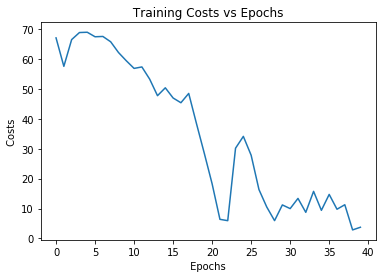

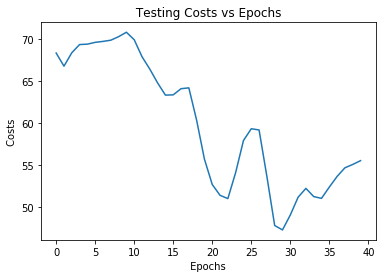

In [24]:
import matplotlib.pyplot as plt
import random

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    ctrain = []
    ctest = []
    Outputs = []
    
    batch_size = 100
    no_of_batches = 19
    for i in range(40):
        for j in range(no_of_batches):
            '''
            idx = random.sample(range(1900), 100)
            X = Xtrain[idx]
            Y = Ytrain[idx]
            '''
            X = Xtrain[j*batch_size : j*batch_size + batch_size]
            Y = Ytrain[j*batch_size : j*batch_size + batch_size]
            
            sess.run(train,feed_dict = {tf_X : X , tf_Y : Y})
            Outputs.append(sess.run(output , feed_dict = {tf_X : Xtest}))
            ctrain.append(sess.run(loss, feed_dict={tf_X : X,tf_Y : Y}))
            ctest.append(sess.run(loss, feed_dict={tf_X : Xtest,tf_Y : Ytest}))
            print('Epoch :',i,' Batch :' , j , 'Cost :',ctrain[i])
    
    
# Lets plot the Data's

plt.plot(ctrain)
plt.title(" Training Costs vs Epochs ")
plt.xlabel(" Epochs ")
plt.ylabel(" Costs ")
plt.show()

plt.plot(ctest)
plt.title(" Testing Costs vs Epochs ")
plt.xlabel(" Epochs ")
plt.ylabel(" Costs ")
plt.show()

In [25]:
def Accuracy(pred):
    for i in range(len(pred)) :
        if pred[i] > 0.5:
            pred[i] = 1
        
        else :
            pred[i] = 0
            
    counter = 0
    
    for i in range(len(pred)):
        if pred[i] == int(Ytest[i]):
            counter = counter + 1
            
    return float(counter/len(pred))

In [26]:
Accuracies = []

for i in Outputs:
    Accuracies.append(Accuracy(i))

In [27]:
print(max(Accuracies))

0.88
